In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans

from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import SilhouetteVisualizer

from collections import Counter 
from sklearn.metrics import silhouette_samples, silhouette_score
import os
import random
import re

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

Lemmatizing was used in the Preprocessing now we will do word embedding
https://stackoverflow.com/questions/23877375/word2vec-lemmatization-of-corpus-before-training

In [2]:
df = pd.read_csv('../../data/p_content.csv')
df1 = df[['ID_GodotObject','merged_text']]
print(df1.shape)
print(df1.dtypes)
df1.head()

(103, 2)
ID_GodotObject     int64
merged_text       object
dtype: object


,ID_GodotObject,merged_text
0,2000115059032,﻿20sars-cov-2maskenpflicht medizinisch_Persona...
1,2000116305030,﻿20_Coronavirus schrittweise Einführung Masken...
2,2000116325081,﻿20kein Ende Sicht Regierung setzen Maske bei ...
3,2000116346340,﻿20_Coronavirus Maskenpflicht Supermarkt späte...
4,2000116371728,﻿20_Coronavirus Sonderbeauftragter Clemens Aue...


The model produces high-dimensional vectors, where the size parameter sets the number of dimensions. The optimal number of dimensions depends on the size of the dataset. In our case, 100 dimensions seem to be working very well. min_count parameter controls the minimum frequency of words.



https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/


## Apply function to remove duplicates


Duplicate words can be considered as additional context for the model and can potentially improve the quality of the word embeddings. However, if you have a very large number of duplicates, it may slow down the training process and potentially lead to overfitting. In such cases, it might be beneficial to remove duplicates to speed up training and improve generalization.

Overall, whether or not to remove duplicates when using Word2vec will depend on the specific data and the goals of your word embedding task. It is a good idea to try both approaches and see which one gives better results on your data.

In [3]:
# Remove duplicated after preprocessing
#_, idx = np.unique(df1["tokens"], return_index=True)
#df1 = df1.iloc[idx, :]

#print(df1.shape)
#df1.head()
                

### Check for common words

In [4]:
docs = df1["merged_text"].tolist()
tokenized_docs = df1["merged_text"].map(lambda x: x.split())
tokenized_docs = [[token for token in tokens if token != '--']for tokens in tokenized_docs]
#tokenized_docs = df1["tokens"].tolist()
ids = df1["ID_GodotObject"].tolist()
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)
    
vocab.most_common(10)

[('werden', 246),
 ('ab', 208),
 ('Wien', 200),
 ('Maskenpflicht', 199),
 ('gelten', 199),
 ('geben', 192),
 ('sein', 188),
 ('mehr', 178),
 ('Österreich', 165),
 ('Person', 164)]

### Generate Vectors from document

In [5]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            #print(vectors)
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            print(avg_vec)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [6]:
def vectorize_weigthed_avg(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    # Calculate tf-idf weights for each token in the documents
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform([" ".join(a) for a in list_of_docs])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_weights = dict(zip(feature_names, X.toarray().mean(axis=0)))

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        total_weight = 0
        for token in tokens:
            if token in model.wv:
                try:
                    weight = tfidf_weights[token]
                    vectors.append(weight * model.wv[token])
                    total_weight += weight
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            weighted_avg_vec = vectors.sum(axis=0) / total_weight
            features.append(weighted_avg_vec)
        else:
            features.append(zero_vector)
    return features

In [7]:
#vectorized_docs = vectorize(tokenized_docs, model=model)
#len(vectorized_docs), len(vectorized_docs[0])

In [8]:
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=42)
model.train(tokenized_docs, total_examples=len(tokenized_docs), epochs=10)
print(model.wv.most_similar("Maske")) 
#print(tokenized_docs)


vectorized_docs = vectorize_weigthed_avg(tokenized_docs, model=model)
#vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

[('mund-nasen-schutz', 0.9989187121391296), ('Supermärkt', 0.9984760880470276), ('weiterhin', 0.9983647465705872), ('Klasse', 0.9983058571815491), ('Ffp2-mask', 0.9982562065124512), ('einhalten', 0.9982369542121887), ('dafür', 0.9982022643089294), ('verpflichtend', 0.9981527328491211), ('außerdem', 0.9981510043144226), ('müssen', 0.9981331825256348)]


(103, 100)

C:\Users\e11925939\AppData\Local\Temp\8\ipykernel_44700\466706601.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


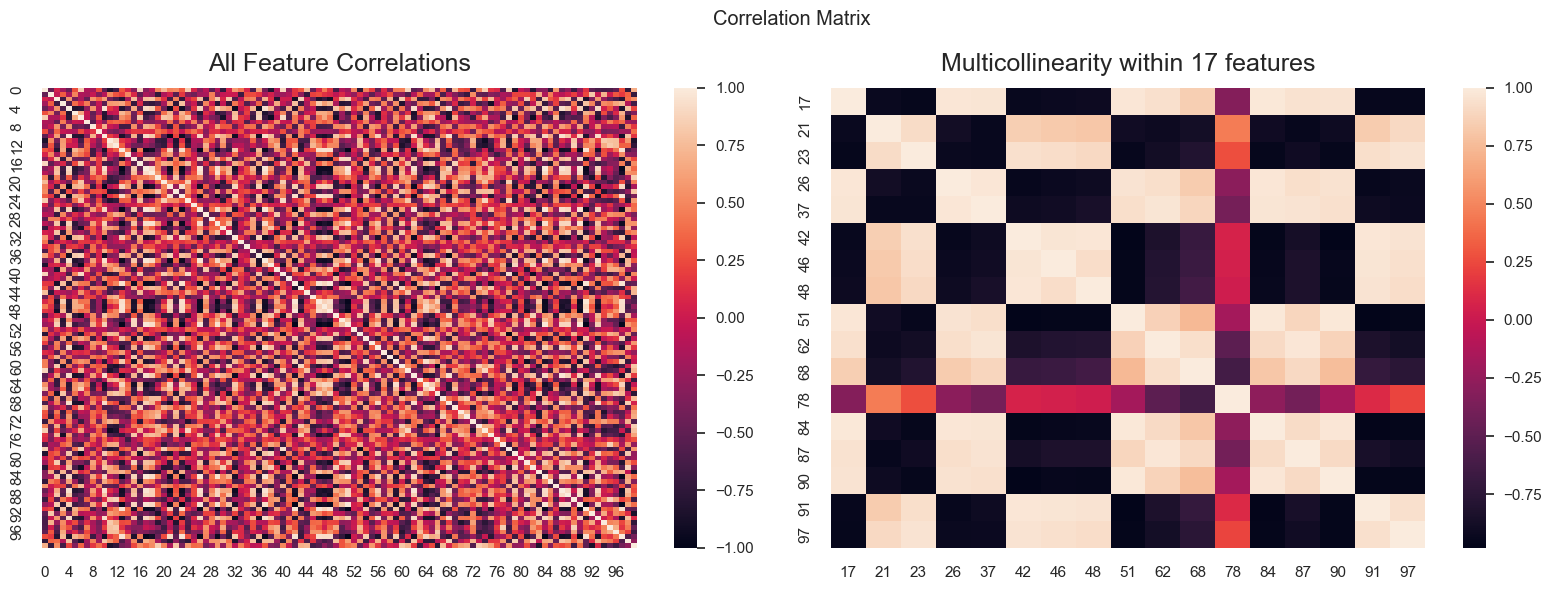

In [9]:
# analyse the feature quality
sns.set()

vectorized_docs_df = pd.DataFrame(vectorized_docs)
corr_matrix = vectorized_docs_df.corr().abs()


# Find the columns that have a correlation greater than 0.9
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

#high_corr_hm = sns.heatmap(high_corr), vmin=-1, vmax=1, cmap='BrBG')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle("Correlation Matrix")
sns.heatmap(vectorized_docs_df.corr(), vmin=-1, vmax=1,ax=axs[0])
axs[0].set_title('All Feature Correlations', fontdict={'fontsize':18}, pad=12)
sns.heatmap(vectorized_docs_df[to_drop].corr(),ax=axs[1])
axs[1].set_title('Multicollinearity within ' + str(len(to_drop)) + ' features', fontdict={'fontsize':18}, pad=12)


plt.tight_layout()
plt.savefig("word2vec-heatmap.png", facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)

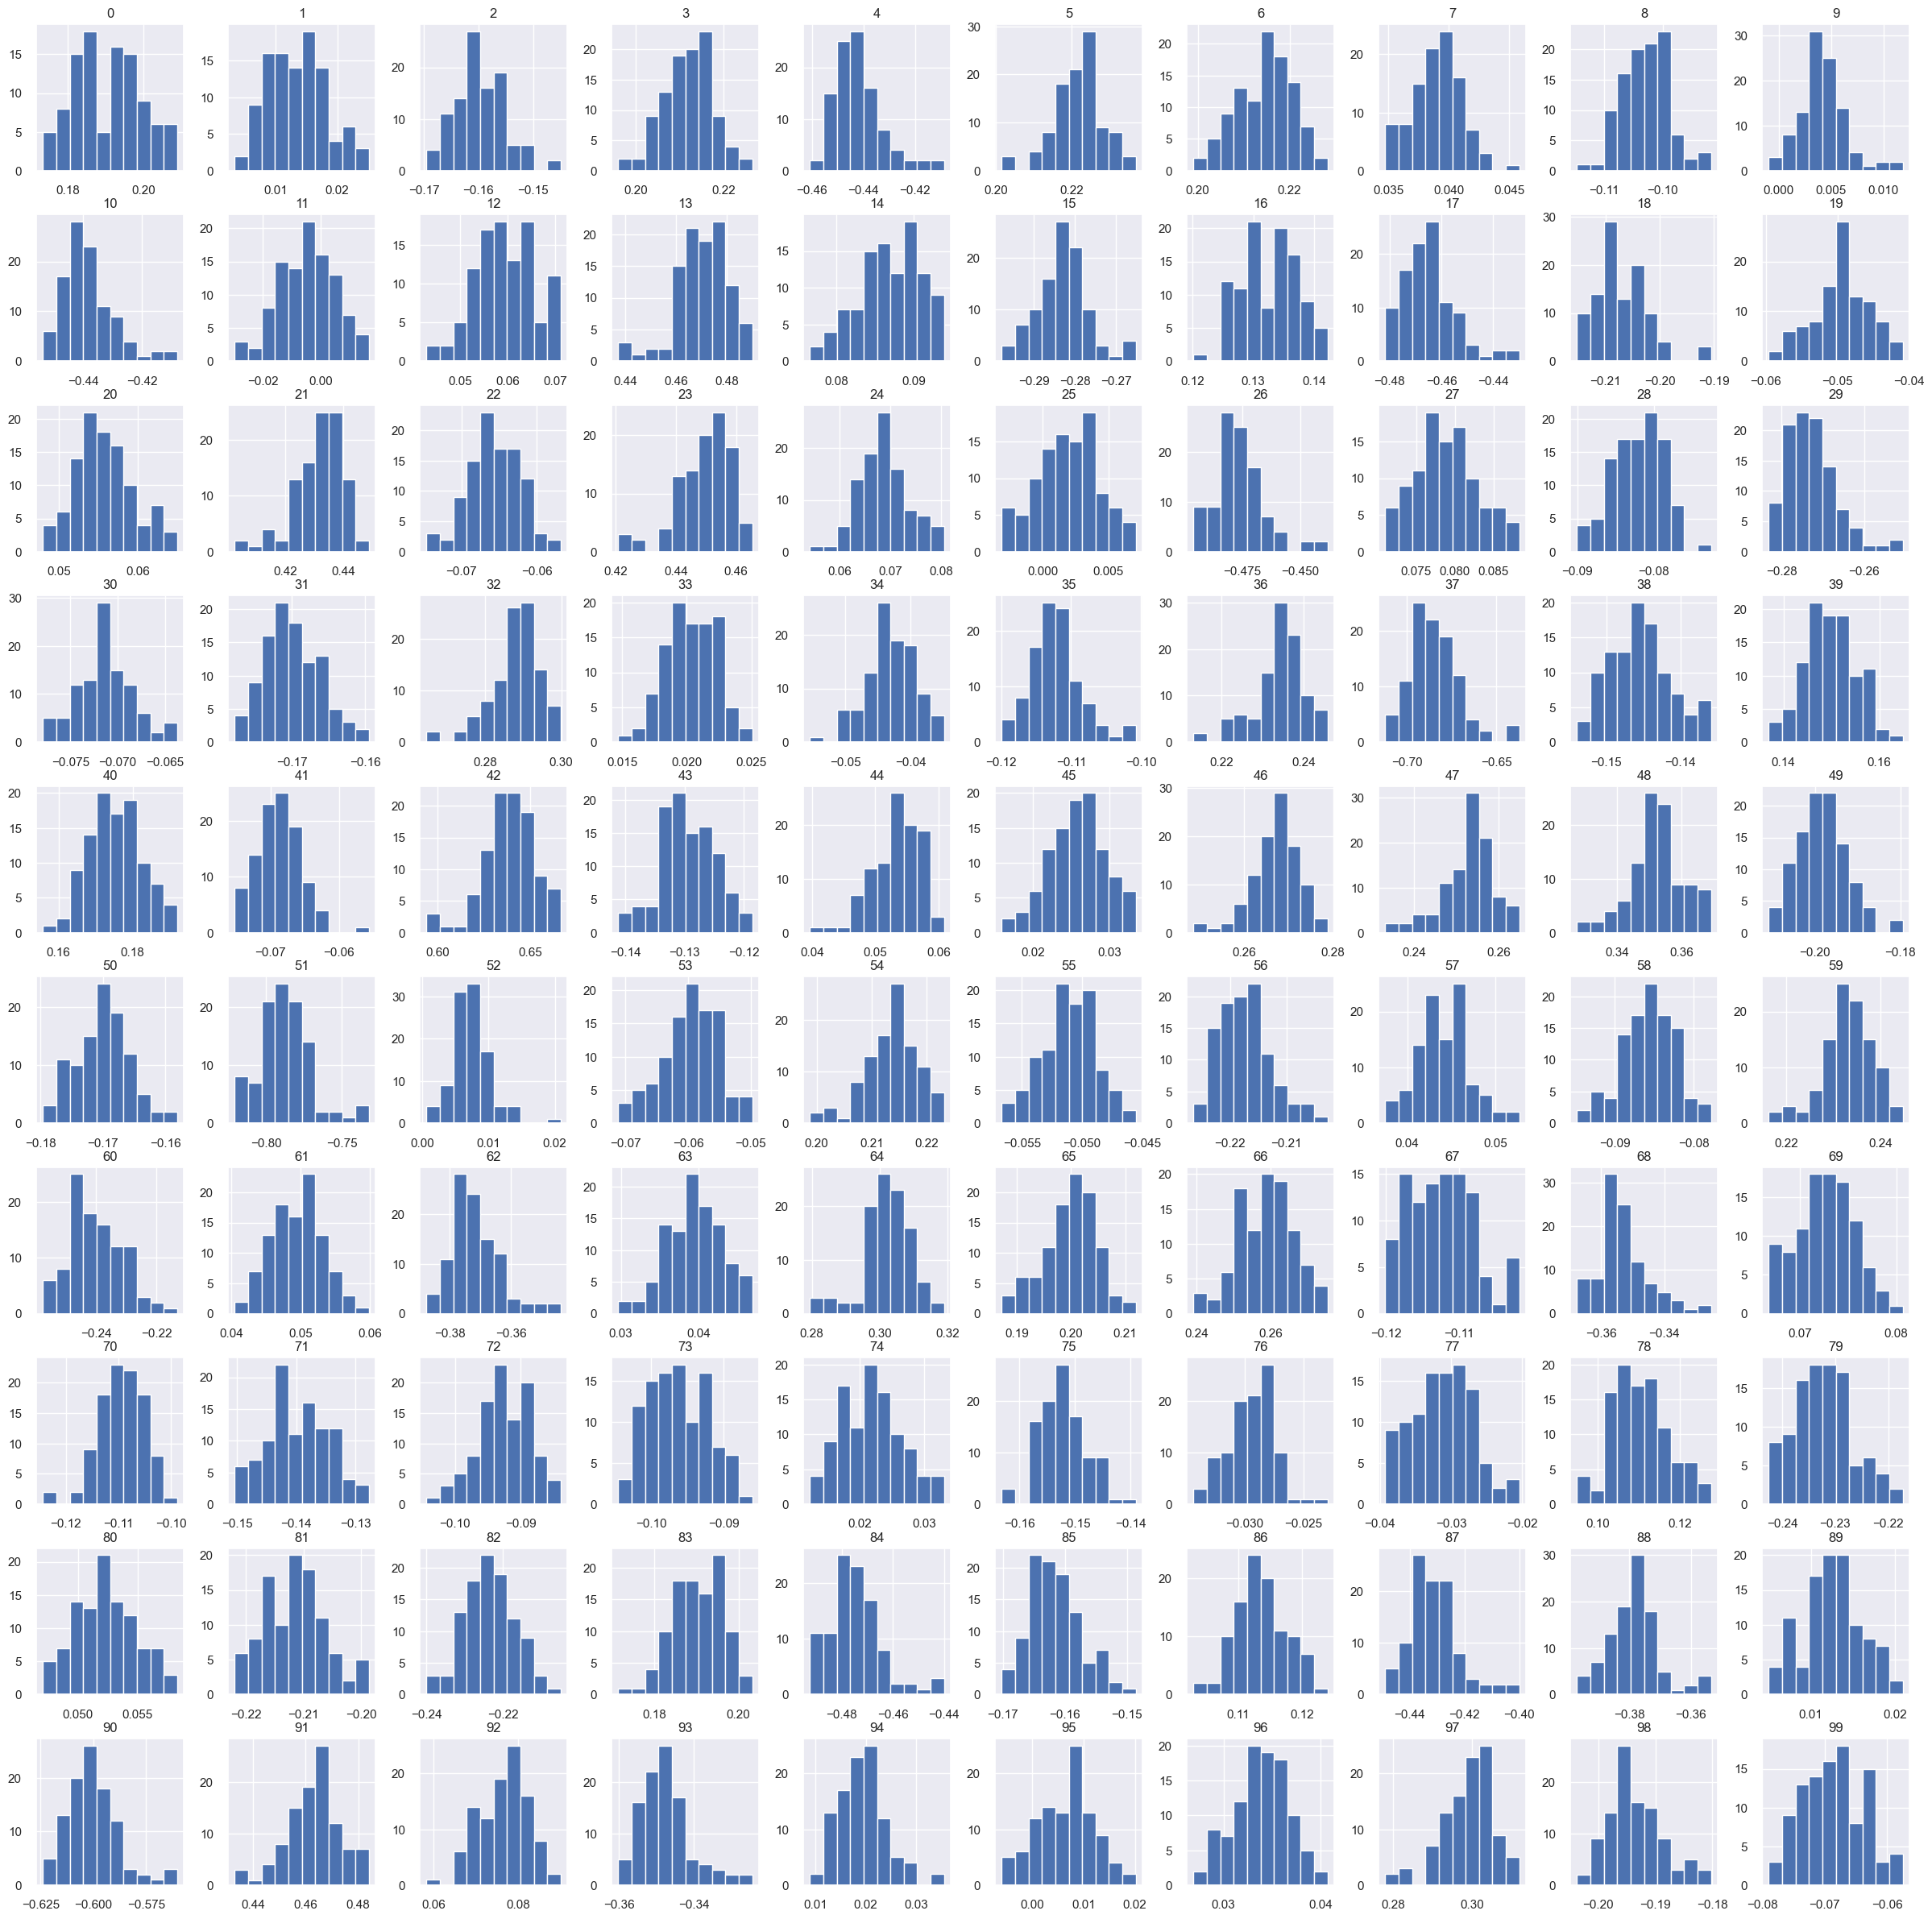

In [10]:
vectorized_docs_df.hist(figsize=(30,30))
plt.savefig("word2vec-feature_dist.png", facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)
plt.show()

#Log Transform Feature 14, 23,32,51,66,97
#vectorized_docs_df[14]=np.log(vectorized_docs_df[14])
#vectorized_docs_df[23]=np.log(vectorized_docs_df[23])
#vectorized_docs_df[32]=np.log(vectorized_docs_df[32])
#vectorized_docs_df[51]=np.log(vectorized_docs_df[51])
#vectorized_docs_df[66]=np.log(vectorized_docs_df[66])
#vectorized_docs_df[97]=np.log(vectorized_docs_df[97])

#vectorized_docs_df[97]


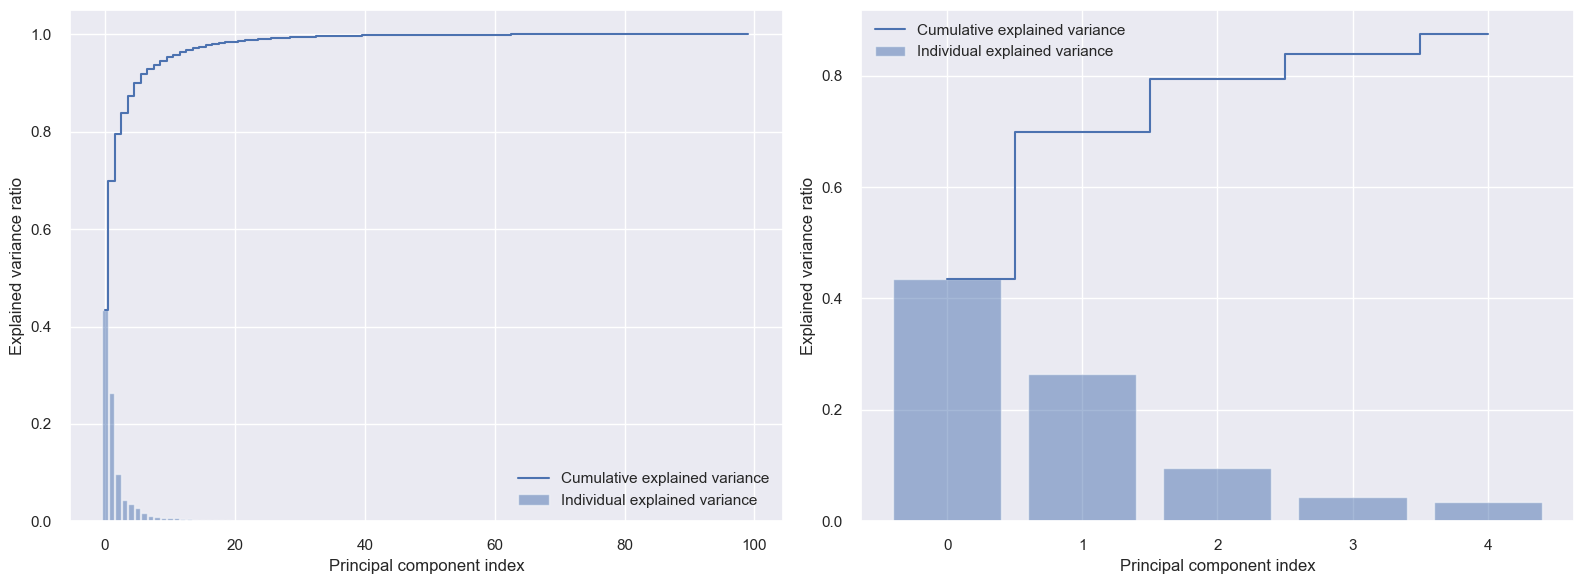

<Figure size 800x550 with 0 Axes>

In [11]:
#PCA to fight Multicollinearity
# Scale the dataset;
sc = StandardScaler()
vectorized_docs_scaled = sc.fit_transform(vectorized_docs_df.to_numpy())
#Perform PCA
pca = PCA()
pca.fit(vectorized_docs_scaled)
exp_var_pca = pca.explained_variance_ratio_
#Cumulative sum of eigenvalues
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

pca5 = PCA(n_components=5)
pca5.fit(vectorized_docs_scaled)
exp_var_pca5 = pca5.explained_variance_ratio_
#Cumulative sum of eigenvalues
cum_sum_eigenvalues5 = np.cumsum(exp_var_pca5)

#Visualisation
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', 
        label='Individual explained variance')
axs[0].step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',
         label='Cumulative explained variance')
axs[0].set_ylabel('Explained variance ratio')
axs[0].set_xlabel('Principal component index')
axs[0].legend(loc='best')
axs[1].bar(range(0,len(exp_var_pca5)), exp_var_pca5, alpha=0.5, align='center', 
        label='Individual explained variance')
axs[1].step(range(0,len(cum_sum_eigenvalues5)), cum_sum_eigenvalues5, where='mid',
         label='Cumulative explained variance')
axs[1].set_ylabel('Explained variance ratio')
axs[1].set_xlabel('Principal component index')
axs[1].legend(loc='best')
plt.tight_layout()


plt.savefig("word2vec-pca.png", facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)

# apply PCA nComponent 3 to vector data
pca3 = PCA(n_components=3)
X = pca3.fit_transform(vectorized_docs_scaled)
#print(X)

In [12]:
# View Distribution of the data

## KNN Clustering

Select number of clusters by Silhoutte Score

- Silhouette score for a set of sample data points is used to measure how dense and well-separated the clusters are.
- Silhouette score takes into consideration the intra-cluster distance between the sample and other data points within the same cluster (a) and inter-cluster distance between the sample and the next nearest cluster (b).
- The silhouette score falls within the range [-1, 1].
- The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.
- The silhouette plots can be used to select the most optimal value of the K (no. of cluster) in K-means clustering.
- The aspects to look out for in Silhouette plots are cluster scores below the average silhouette score, wide fluctuations in the size of the clusters, and also the thickness of the silhouette plot.



C:\Users\e11925939\Anaconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.2695171


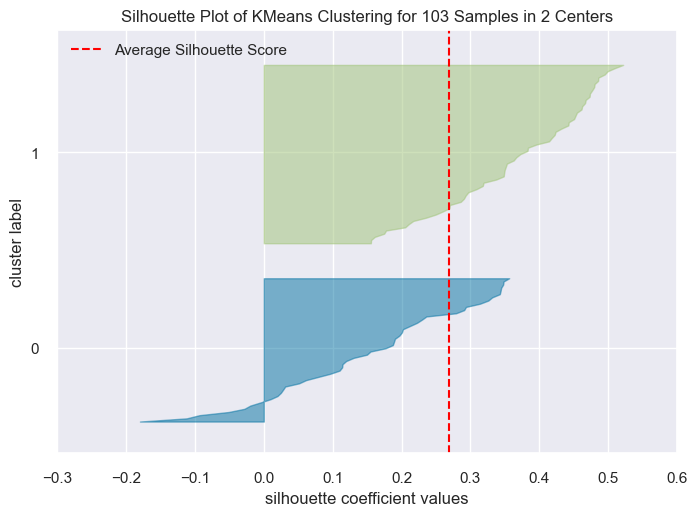

C:\Users\e11925939\Anaconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.3181915


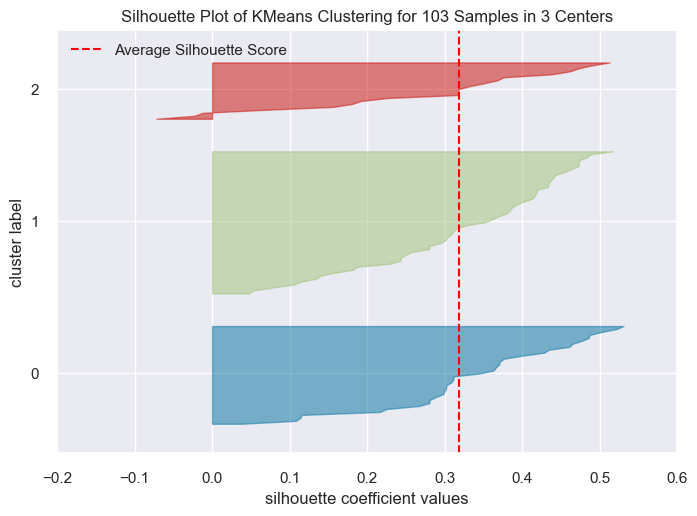

C:\Users\e11925939\Anaconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.27024582


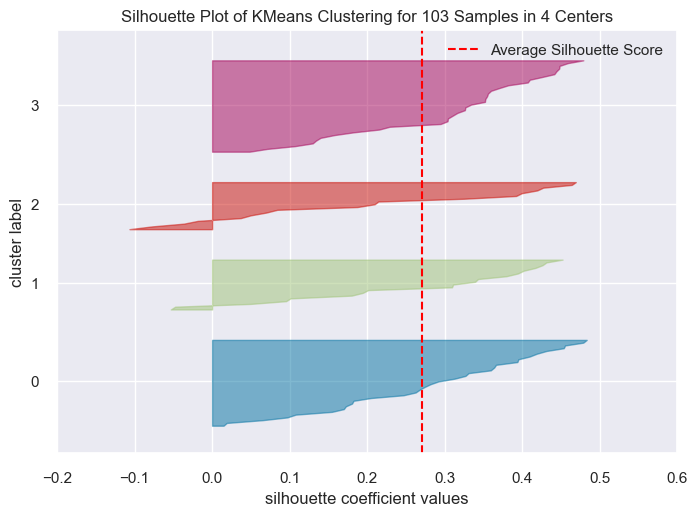

C:\Users\e11925939\Anaconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.28148848


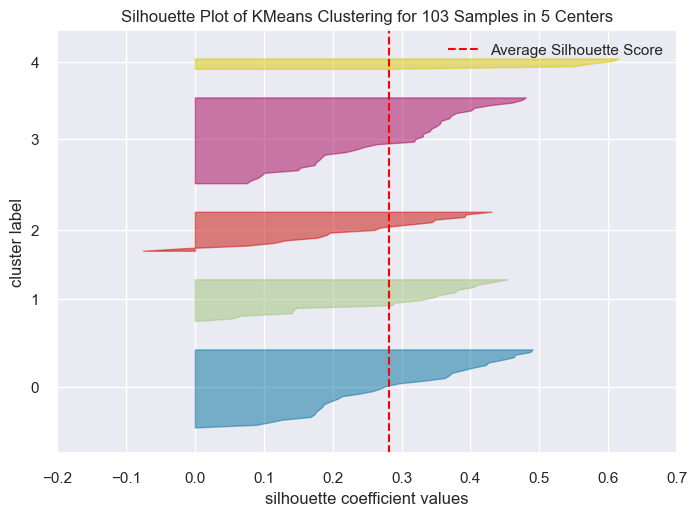

C:\Users\e11925939\Anaconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.27408758


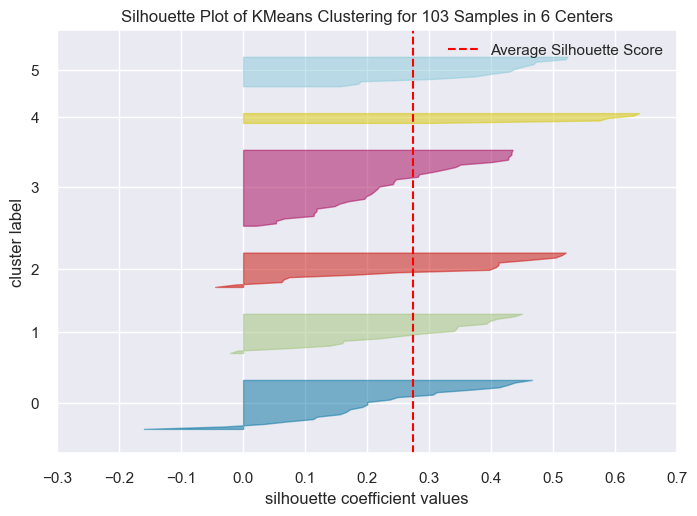

C:\Users\e11925939\Anaconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.26369837


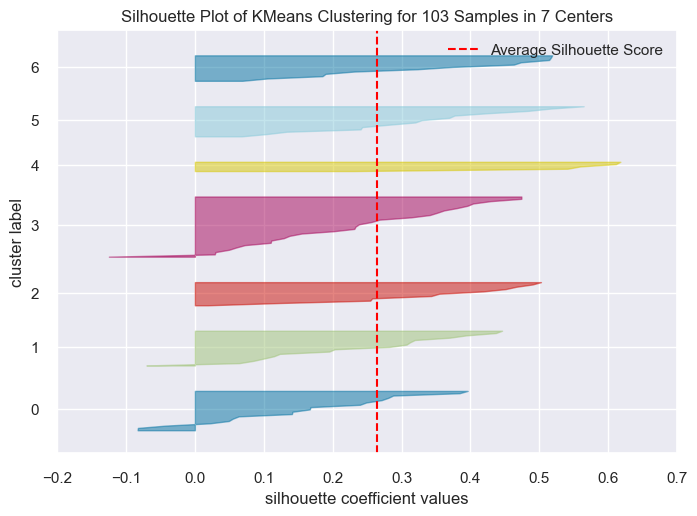

C:\Users\e11925939\Anaconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.2743666


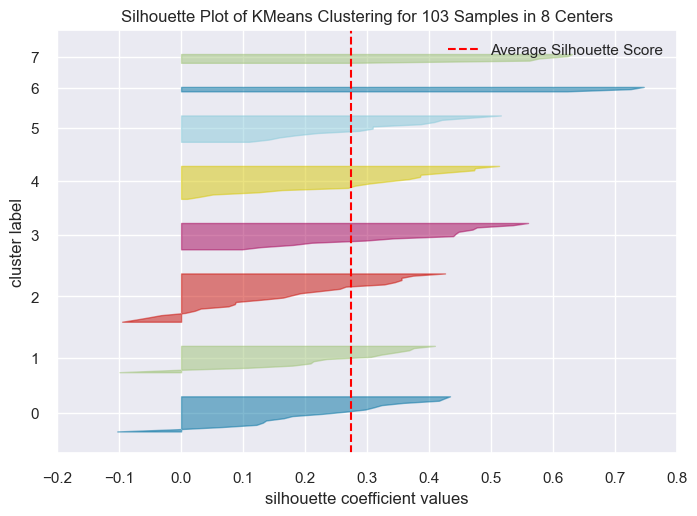

C:\Users\e11925939\Anaconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 9 The average silhouette_score is : 0.2755438


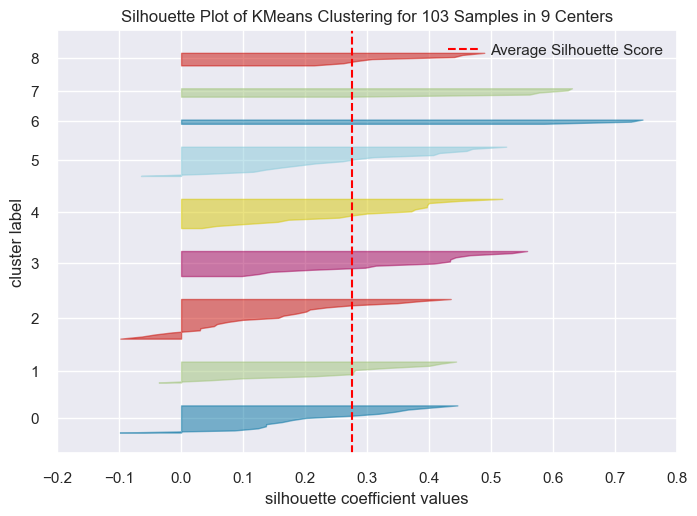

C:\Users\e11925939\Anaconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.30817768


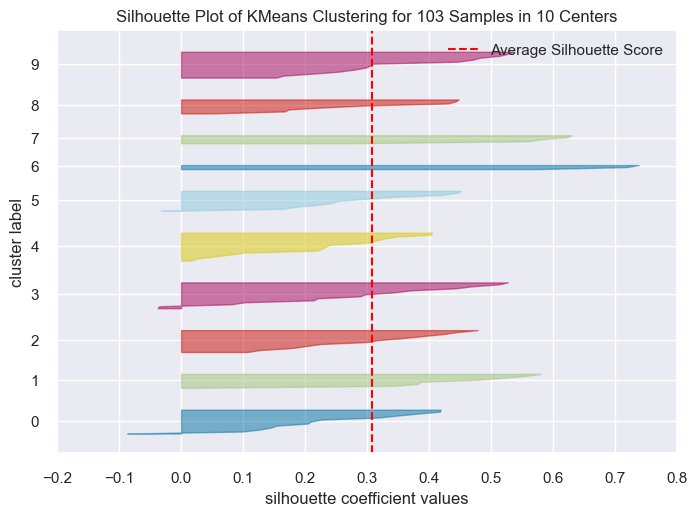

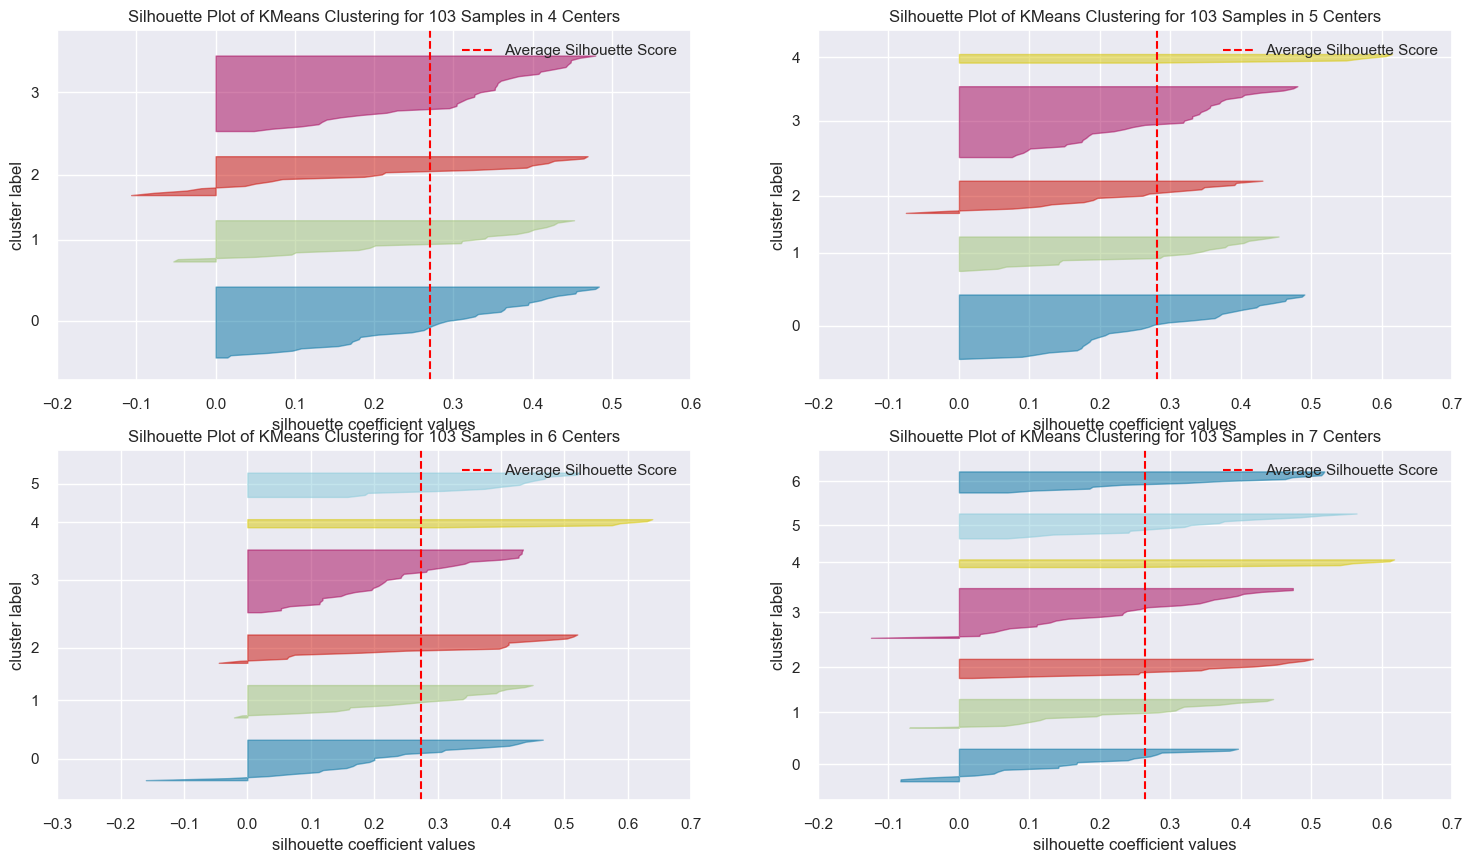

In [13]:
#n = 7

#kmeans = KMeans(n_clusters = n)
#kmeans.fit(X)
#y_kmeans = kmeans.predict(X)
#df2 = df1[['ID_GodotObject']].copy()
#df2['cluster_value'] = y_kmeans
#df2.to_csv('../../data/feature/knn_clustering1.csv', encoding='utf-8', index=False)

#df2.head()
rs = 42

#knn_per_k = [KMeans(n_clusters = n, random_state=rs).fit(X) for n in range(1, 10)]
#ilhouette_scores = [silhouette_score(scaled_data, model.labels_) or model in kmeans_per_k[1:]]
trained_models = {}
for k in range(2, 11):
    model = KMeans(n_clusters=k, n_init="auto", random_state=rs)
    labels = model.fit_predict(X)
    trained_models[k] = (model, labels)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, labels)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    silhouette_visualizer(model, X, colors='yellowbrick')
    
    
#visualization
fig, ax = plt.subplots(2, 2, figsize=(18, 10))
x = 0
y = 0
for i in range(4,8):
    visualizer = SilhouetteVisualizer(trained_models[i][0], colors='yellowbrick', ax=ax[y,x])
    visualizer.fit(X)        
    visualizer.finalize()        
    x += 1
    if x == 2:
        x = 0
        y += 1
    
    
plt.savefig("word2vec-knn-silhoutte.png", facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)


now I decided to print the text for each article in each cluster and write the result to a csv file, for later extracting impiortand opinions per cluster

In [14]:
n = 4
df2 = df1[['ID_GodotObject']].copy()
df2['cluster_value'] = trained_models[n][1]
df2.to_csv('../../data/feature/knn_clustering.csv', encoding='utf-8', index=False)

for i in range(n):
    rslt_df = df2[df2['cluster_value'] == i].copy()
    txt_df = df1[['ID_GodotObject','merged_text']].copy()
    rslt_df = pd.merge(rslt_df, txt_df, on="ID_GodotObject")
    rslt_df.to_csv('../../data/feature/clusters/' + str(i) + '_cluster.csv', encoding='utf-8', index=False)
    #print(rslt_df.shape)


